In [1]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy
import random

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models

In [3]:
data_path = 'C:/kotorch/AutoCrawler-master/download/'

In [4]:
normalize = transforms.Normalize(mean=[0.485,0.456,0.406],
                                std=[0.229,0.224,0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ])
}

image_datasets = {
    'train':
    datasets.ImageFolder(data_path + 'train', data_transforms['train']),
    'validation':
    datasets.ImageFolder(data_path + 'validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                               batch_size = 128,
                               shuffle=True,
                               num_workers=0),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                               batch_size = 128,
                               shuffle=False,
                               num_workers=0)
}

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False # 미적분 막기
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 5)).to(device)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [8]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [9]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 1.2634, acc: 0.4952
validation loss: 0.9938, acc: 0.6171
Epoch 2/3
----------
train loss: 0.9490, acc: 0.6361
validation loss: 0.8508, acc: 0.6721
Epoch 3/3
----------
train loss: 0.8526, acc: 0.6784
validation loss: 0.8264, acc: 0.6835


In [10]:
PATH = 'C:/kotorch/AutoCrawler-master/weights.h5'
torch.save(model_trained.state_dict(), PATH)

In [11]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 5)).to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [19]:
validation_img_paths = ["validation/심상정/google_0048.jpg",
                        "validation/추미애/google_0013.jpg",
                        "validation/이낙연/naver_0362.jpg",
                       "validation/이낙연/naver_0399.jpg",
                       "validation/홍준표/naver_0222.jpg"]
img_list = [Image.open(data_path + img_path) for img_path in validation_img_paths]

In [20]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [21]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ 4.1084, -2.2555, -0.3536,  0.1726,  0.3040],
        [ 0.9340, -2.9030, -1.0609,  4.2377, -0.9597],
        [-1.2807,  0.3266,  1.0073,  2.3019, -0.4082],
        [-1.3932,  0.4669,  1.2853,  1.2710,  0.6604],
        [-2.4847,  0.9176,  1.1247,  0.7128,  2.6404]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [22]:
with open ('C:/kotorch/AutoCrawler-master/keywords.txt', 'rt', encoding = 'UTF8' ) as f:
    labels = [line.strip() for line in f.readlines()]

In [23]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[9.47807133e-01, 1.63272955e-03, 1.09378621e-02, 1.85106713e-02,
        2.11115796e-02],
       [3.50621007e-02, 7.55869725e-04, 4.76915902e-03, 9.54135776e-01,
        5.27719082e-03],
       [1.84494480e-02, 9.20508131e-02, 1.81813553e-01, 6.63541019e-01,
        4.41452377e-02],
       [2.26550084e-02, 1.45547211e-01, 3.29920560e-01, 3.25255007e-01,
        1.76622242e-01],
       [3.83682339e-03, 1.15223885e-01, 1.41737297e-01, 9.38877836e-02,
        6.45314157e-01]], dtype=float32)

In [24]:
from matplotlib import font_manager, rc

font_path = 'C:/kotorch/font/NanumBarunGothic.ttf'
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

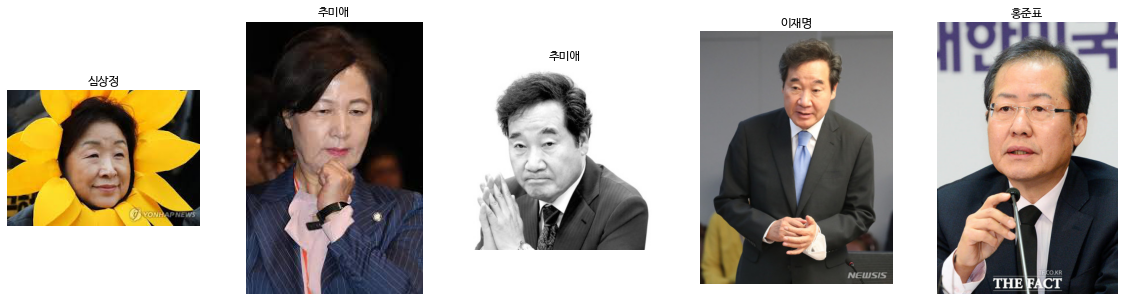

In [25]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title((labels[np.argmax(pred_probs[i])]))
    ax.imshow(img)